In [13]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from Data_preparation_Library import *
from sklearn.preprocessing import MinMaxScaler,StandardScaler

<AxesSubplot:title={'center':'sEMG Data'}>

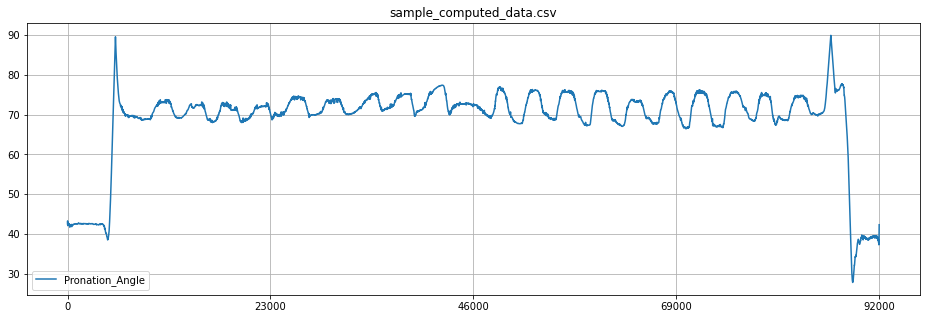

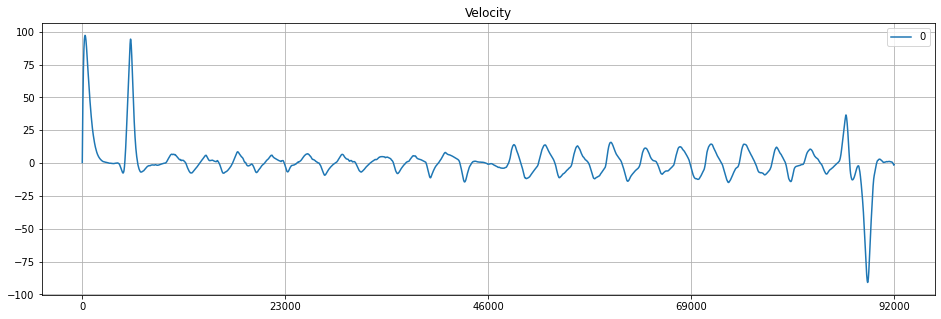

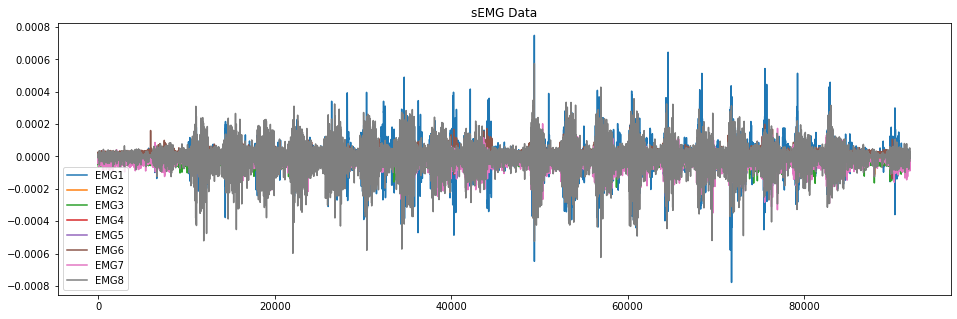

In [14]:
file = 'sample_computed_data.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Pronation_Angle'] # 'Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle'
df = pd.read_csv(file,index_col=0)
df[angle_lables].plot(figsize=(16,5),title=file,grid=True,xticks=np.linspace(0,len(df),5))
emg_df = df[emg_labels]
arr = np.array(df['Pronation_Angle'])

b,a = signal.butter(1, 1,fs=2000)
arr = signal.lfilter(b, a,arr)

# arr = np.rad2deg(np.unwrap(np.deg2rad(arr)))
arr = np.diff(list(arr))
arr = arr/(1/2000)
b,a = signal.butter(1, 1,fs=2000)
arr = signal.lfilter(b, a,arr)
# arr = arr/df.index

pd.DataFrame(arr).plot(figsize=(16,5),title='Velocity',grid=True,xticks=np.linspace(0,len(df),5))
emg_df.plot(figsize=(16,5),title='sEMG Data')

In [4]:
X,y = prep_data_velocity(df,250,interval=10,Normalize=False,rms=False,angle_label ='Pronation_Angle')
X.shape

(9175, 250, 8)

In [5]:
X_mean = np.zeros(X[0].shape)
for x in X:
    X_mean = X_mean + x
X_mean = X_mean/X.shape[0]
X_std = np.sqrt(variance(X))
np.save('mean_std',np.array([X_mean,X_std]))

In [6]:
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

In [6]:
y_mean = 0
for v in y:
  y_mean = y_mean + v
y_mean = y_mean/y.shape[0]
y_std = np.sqrt(variance(y))
np.save('vel_mean_std',np.array([y_mean,y_std]))

In [10]:
scaler = StandardScaler()
y = scaler.fit_transform(y.reshape(y.shape[0],1))

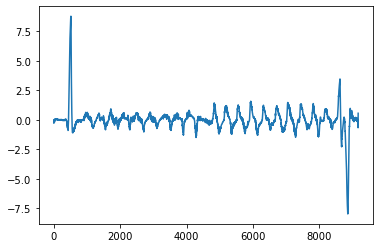

In [11]:
plt.plot(y)

In [ ]:
y_new = []
for v in tqdm(y):
    y_new.append((v-y_mean)/y_std)
y = np.array(y_new)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

In [21]:
n_outputs = 1
in_shape = (X.shape[1],X.shape[2])

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=in_shape))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=26, kernel_size=3, activation='relu'))

# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
# model.add(Dense(64,activation='relu'))
model.add(Dense(n_outputs))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 248, 64)           1600      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 246, 32)           6176      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 244, 26)           2522      
_________________________________________________________________
dropout_2 (Dropout)          (None, 244, 26)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6344)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6345      
Total params: 16,643
Trainable params: 16,643
Non-trainable params: 0
__________________________________________________

In [25]:
history = model.fit(X,y,epochs=100,validation_split=0.2,shuffle=True,batch_size=1000)

Epoch 1/100
8/8 [==============================] - 0s 35ms/step - loss: 0.0197 - val_loss: 2.5729
Epoch 2/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0209 - val_loss: 2.5855
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0180 - val_loss: 2.5666
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0181 - val_loss: 2.5378
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0185 - val_loss: 2.6181
Epoch 6/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0193 - val_loss: 2.5703
Epoch 7/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0186 - val_loss: 2.5467
Epoch 8/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0195 - val_loss: 2.5112
Epoch 9/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0193 - val_loss: 2.5445
Epoch 10/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0181 - val_loss: 2.5407
Epoch 11/100
8/8 [=

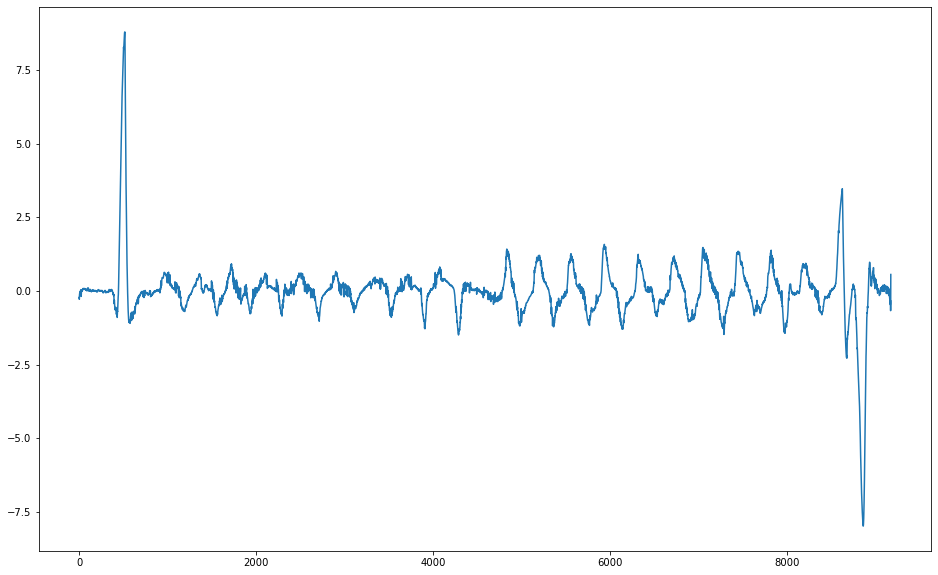

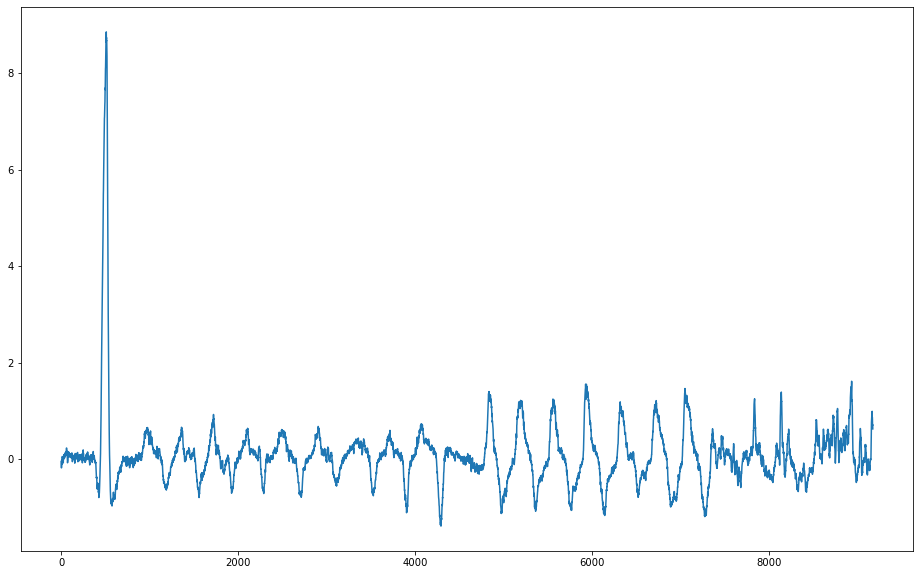

In [26]:
pred = model.predict(X)
true = y
plt.figure(figsize=(16,10))
plt.plot(true)
plt.figure(figsize=(16,10))
plt.plot(pred)

In [12]:
def get_velocity(arr,sr):
    dt = 1/sr
    diff = np.diff(arr)
    diff = diff/dt
    return diff